In [1]:
from collections import defaultdict
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyprojroot
import seaborn as sns

import searchnets

In [2]:
mpl.style.use(['seaborn-darkgrid', 'seaborn-paper'])

paths

In [3]:
ROOT = pyprojroot.here()
DATA_DIR = ROOT.joinpath('data')
RESULTS_ROOT = ROOT.joinpath('results')

SEARCHSTIMS_ROOT = RESULTS_ROOT.joinpath('searchstims')
RESULTS_GZ_ROOT = SEARCHSTIMS_ROOT.joinpath('results_gz')

SEARCHSTIMS_OUTPUT_ROOT = ROOT.joinpath('../visual_search_stimuli')
alexnet_data_csv_path = SEARCHSTIMS_OUTPUT_ROOT.joinpath(
    'alexnet_multiple_stims/alexnet_multiple_stims_128000samples_balanced_split.csv')
VGG16_data_csv_path = SEARCHSTIMS_OUTPUT_ROOT.joinpath(
    'VGG16_multiple_stims/VGG16_multiple_stims_128000samples_balanced_split.csv'
)

constants

In [4]:
LEARNING_RATE = 1e-3

NET_NAMES = [
    'alexnet',
    'VGG16',
    'CORnet_Z'
]

METHODS = [
    'initialize',
    'transfer'
]

## munge results into a dataframe

In [5]:
df_list = []

for net_name in NET_NAMES:
    for method in METHODS:
        results_gz_path = sorted(RESULTS_GZ_ROOT.glob(f'**/*{net_name}*{method}*gz'))
        if len(results_gz_path) != 1:
            raise ValueError(f'found more than one results.gz file: {results_gz_path}')
        results_gz_path = results_gz_path[0]

        if net_name == 'alexnet' or net_name == 'CORnet_Z':
            csv_path = alexnet_data_csv_path
        elif net_name == 'VGG16':
            csv_path = VGG16_data_csv_path
        else:
            raise ValueError(f'no csv path defined for net_name: {net_name}')

        df = searchnets.analysis.searchstims.results_gz_to_df(results_gz_path, 
                                                              csv_path, 
                                                              net_name,
                                                              method,
                                                              LEARNING_RATE)
        df_list.append(df)
            
df_all = pd.concat(df_list)

/home/bart/Documents/repos/L2M/visual-search-nets/src/searchnets/analysis/searchstims.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_testset['y_true'] = df_testset['target_condition'] == 'present'
/home/bart/Documents/repos/L2M/visual-search-nets/src/searchnets/analysis/searchstims.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_testset['y_pred'] = preds_per_model[key]
/home/bart/Documents/repos/L2M/visual-search-nets/src/searchnets/analysis/searchstims.py:21: RuntimeWarning: invalid value e

Get just the transfer learning results, then group by network, stimulus, and set size, and compute the mean accuracy for each set size.

In [6]:
df_transfer = df_all[df_all['method'] == 'transfer']
df_transfer_acc_mn = df_transfer.groupby(['net_name', 'stimulus', 'set_size']).agg({'accuracy':'mean'})
df_transfer_acc_mn = df_transfer_acc_mn.reset_index()

Make one more `DataFrame` where variable is difference of mean accuracies on set size 1 and set size 8.

We use this below to organize the figure, and to show a heatmap with a marginal distribution.

In [7]:
records = defaultdict(list)

for net_name in df_transfer_acc_mn['net_name'].unique():
    df_net = df_transfer_acc_mn[df_transfer_acc_mn['net_name'] == net_name]
    for stim in df_net['stimulus'].unique():
        df_stim = df_net[df_net['stimulus'] == stim]
        set_size_1_acc = df_stim[df_stim['set_size'] == 1]['accuracy'].values.item()
        set_size_8_acc = df_stim[df_stim['set_size'] == 8]['accuracy'].values.item()
        acc_diff = set_size_1_acc - set_size_8_acc
        records['net_name'].append(net_name)
        records['stimulus'].append(stim)
        records['acc_diff'].append(acc_diff)

df_acc_diff = pd.DataFrame.from_records(records)
df_acc_diff = df_acc_diff[['net_name', 'stimulus', 'acc_diff']]

columns will be stimuli, in increasing order of accuracy drop across models

In [8]:
stim_acc_diff_df = df_acc_diff.groupby(['stimulus']).agg({'acc_diff': 'mean'})
stim_acc_diff_df = stim_acc_diff_df.reset_index()
stim_acc_diff_df = stim_acc_diff_df.sort_values(by='acc_diff')

FIG_COLUMNS = stim_acc_diff_df['stimulus'].values.tolist()
print(FIG_COLUMNS)

['Bx_v_RxRo', 'YT_v_BTBL', 'Bx_v_RxBo', 'RVvGV', 'TvT', 'YT_v_BTYL', 'RVvRHGV', '2_v_5', 'PWVvPWHCV', 'PWVvCV']


rows will be nets, in decreasing order of accuracy drops across stimuli

In [9]:
net_acc_diff_df = df_acc_diff.groupby(['net_name']).agg({'acc_diff': 'mean'})
net_acc_diff_df = net_acc_diff_df.reset_index()
net_acc_diff_df = net_acc_diff_df.sort_values(by='acc_diff', ascending=False)
net_acc_diff_df

FIG_ROWS = net_acc_diff_df['net_name'].values.tolist()
print(FIG_ROWS)

['CORnet_Z', 'alexnet', 'VGG16']


## plot figure

In [10]:
pal = sns.color_palette("Paired")

In [11]:
cmaps = {
    'alexnet': {
        'transfer': {
            'unit_both': pal[0],
            'mn_both': pal[1],
        },
        'initialize': {
            'unit_both': pal[2],
            'mn_both': pal[3],            
        }
    },
    'CORnet_Z': {
        'transfer': {
            'unit_both': pal[4],
            'mn_both': pal[5],
        },
        'initialize': {
            'unit_both': pal[6],
            'mn_both': pal[7],            
        }
    },
    'VGG16': {
        'transfer': {
            'unit_both': pal[8],
            'mn_both': pal[9],
        },
        'initialize': {
            'unit_both': pal[10],
            'mn_both': pal[11],            
        }
    },
}

In [12]:
UNIT_COLORS = {
    'present': 'violet',
    'absent': 'lightgreen',
    'both': 'darkgrey'
}

# default colors used for plotting mean across sampling units in each condition
MN_COLORS = {
    'present': 'magenta',
    'absent': 'lawngreen',
    'both': 'black'
}


def metric_v_set_size_df(df, net_name, method, stimulus, metric, conditions,
                         unit_colors=UNIT_COLORS, mn_colors=MN_COLORS,
                         ax=None, title=None, save_as=None, figsize=(10, 5),
                         set_xlabel=False, set_ylabel=False, set_ylim=True,
                         ylim=(0, 1.1), plot_mean=True, add_legend=False):
    """plot accuracy as a function of visual search task set size
    for models trained on a single task or dataset

    Accepts a Pandas dataframe and column names that determine what to plot.
    Dataframe is produces by searchstims.utils.general.results_csv function.

    Parameters
    ----------
    df : pandas.Dataframe
        path to results.gz file saved after measuring accuracy of trained networks
        on test set of visual search stimuli
    net_name : str
        name of neural net architecture. Must be a value in the 'net_name' column
        of df.
    method : str
        method used for training. Must be a value in the 'method' column of df.
    stimulus : str
        type of visual search stimulus, e.g. 'RVvGV', '2_v_5'. Must be a value in
        the 'stimulus' column of df.
    metric : str
        metric to plot. One of {'acc', 'd_prime'}.
    conditions : list, str
        conditions to plot. One of {'present', 'absent', 'both'}. Corresponds to
        'target_condition' column in df.

    Other Parameters
    ----------------
    unit_colors : dict
        mapping of conditions to colors used for plotting 'sampling units', i.e. each trained
        network. Default is UNIT_COLORS defined in this module.
    mn_colors : dict
        mapping of conditions to colors used for plotting mean across 'sampling units'
        (i.e., each trained network). Default is MN_COLORS defined in this module.
    ax : matplotlib.Axis
        axis on which to plot figure. Default is None, in which case a new figure with
        a single axis is created for the plot.
    title : str
        string to use as title of figure. Default is None.
    save_as : str
        path to directory where figure should be saved. Default is None, in which
        case figure is not saved.
    figsize : tuple
        (width, height) in inches. Default is (10, 5). Only used if ax is None and a new
        figure is created.
    set_xlabel : bool
        if True, set the value of xlabel to "set size". Default is False.
    set_ylabel : bool
        if True, set the value of ylabel to metric. Default is False.
    set_ylim : bool
        if True, set the y-axis limits to the value of ylim.
    ylim : tuple
        with two elements, limits for y-axis. Default is (0, 1.1).
    plot_mean : bool
        if True, find mean accuracy and plot as a separate solid line. Default is True.
    add_legend : bool
        if True, add legend to axis. Default is False.

    Returns
    -------
    None
    """
    if ax is None:
        fig, ax = plt.subplots()
        fig.set_size_inches(figsize)

    df = df[(df['net_name'] == net_name)
            & (df['method'] == method)
            & (df['stimulus'] == stimulus)]

    if not all(
            [df['target_condition'].isin([targ_cond]).any() for targ_cond in conditions]
    ):
        raise ValueError(f'not all target conditions specified were found in dataframe.'
                         f'Target conditions specified were: {conditions}')

    handles = []
    labels = []

    set_sizes = None  # because we verify set sizes is the same across conditions
    net_nums = df['net_number'].unique()
    # get metric across set sizes for each training replicate
    # we end up with a list of vectors we can pass to ax.plot,
    # so that the 'line' for each training replicate gets plotted
    for targ_cond in conditions:
        metric_vals = []
        for net_num in net_nums:
            metric_vals.append(
                df[(df['net_number'] == net_num)
                   & (df['target_condition'] == targ_cond)][metric].values
            )

            curr_set_size = df[(df['net_number'] == net_num)
                               & (df['target_condition'] == targ_cond)]['set_size'].values
            if set_sizes is None:
                set_sizes = curr_set_size
            else:
                if not np.array_equal(set_sizes, curr_set_size):
                    raise ValueError(
                        f'set size for net number {net_num}, '
                        f'target condition {targ_cond},  did not match others'
                    )

        for arr_metric in metric_vals:
            x = np.arange(1, len(set_sizes) + 1) * 2
            ax.plot(x, arr_metric, color=unit_colors[targ_cond], linewidth=2,
                    linestyle='--', marker='o', zorder=1, alpha=0.85, label=None)
            ax.set_xticks(x)
            ax.set_xticklabels(set_sizes)
            ax.set_xlim([0, x.max() + 2])

        if plot_mean:
            mn_metric = np.asarray(metric_vals).mean(axis=0)
            if targ_cond == 'both':
                mn_metric_label = f'mean {metric}, all trials, {method}'
            else:
                mn_metric_label = f'mean {metric}, {targ_cond}, {method}'
            labels.append(mn_metric_label)
            mn_metric_line, = ax.plot(x, mn_metric,
                                      color=mn_colors[targ_cond], linewidth=4,
                                      zorder=0,
                                      label=mn_metric_label)
            ax.set_xticks(x)
            ax.set_xticklabels(set_sizes)
            ax.set_xlim([0, x.max() + 2])
            handles.append(mn_metric_line)



    if title:
        ax.set_title(title)
    if set_xlabel:
        ax.set_xlabel('set size')
    if set_ylabel:
        ax.set_ylabel(metric)
    if set_ylim:
        ax.set_ylim(ylim)

    if add_legend:
        ax.legend(handles=handles,
                  labels=labels,
                  loc='lower left')

    if save_as:
        plt.savefig(save_as)

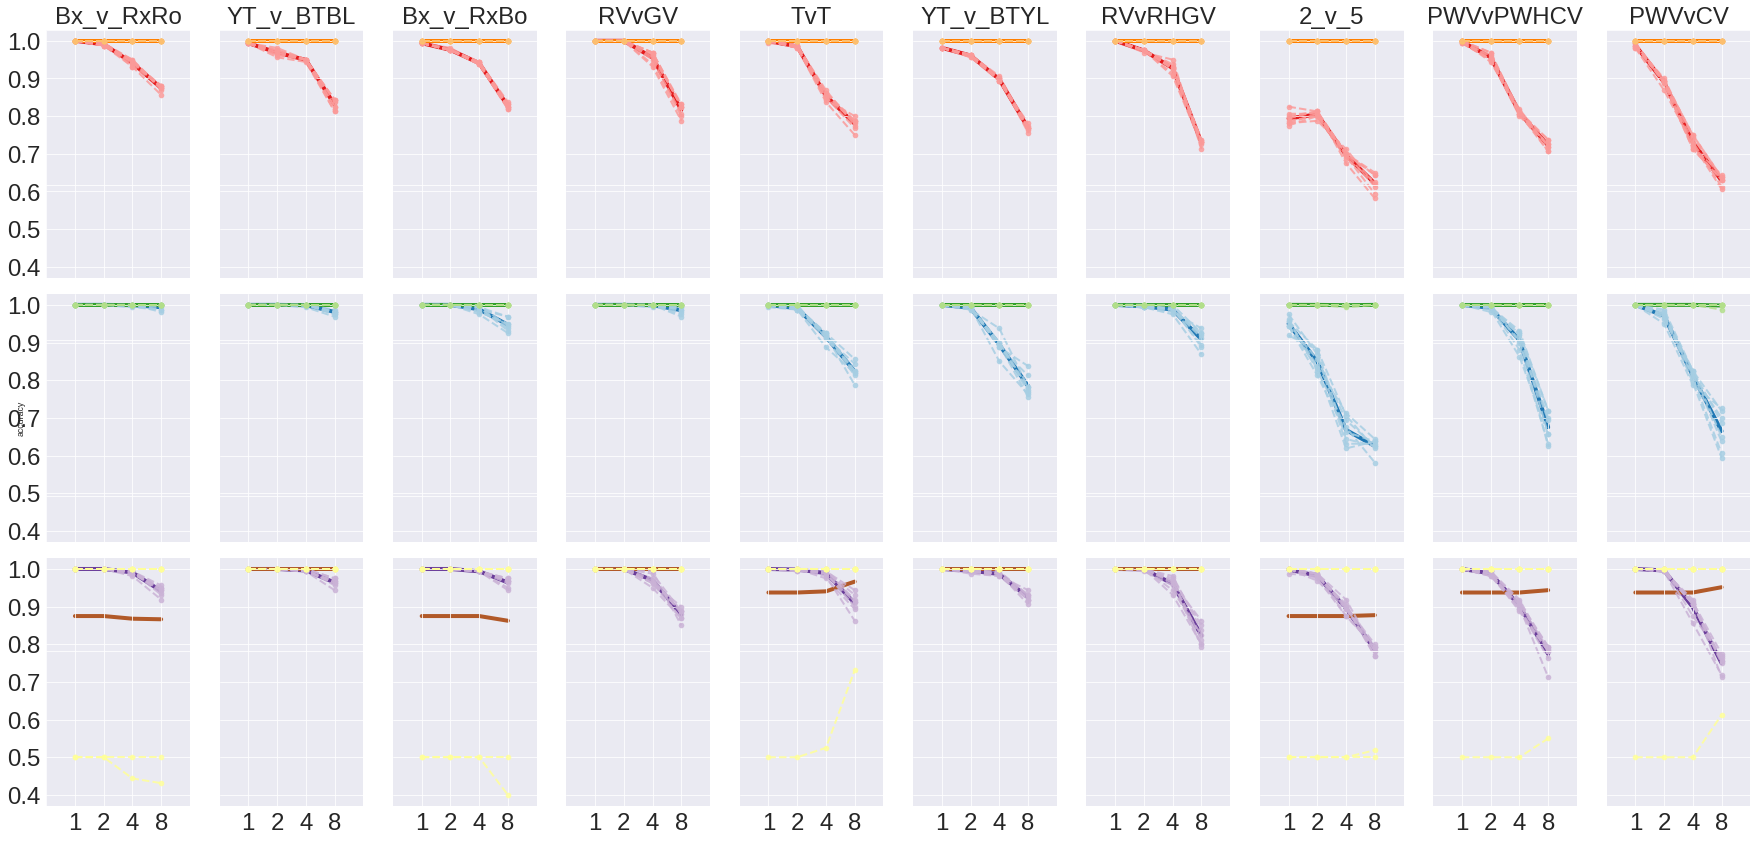

In [13]:
figsize=(25,12)
fig, ax = plt.subplots(3, 10, sharex=True, sharey=True, figsize=figsize)

FONTSIZE = 24
for axis in ax.ravel():
    for item in ([axis.title, axis.xaxis.label, axis.yaxis.label] +
                 axis.get_xticklabels() + axis.get_yticklabels()):
        item.set_fontsize(FONTSIZE)

# add a big axis, hide frame
big_ax = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

add_legend = False

for row, net_name in enumerate(FIG_ROWS):
    df_this_net = df_all[df_all['net_name'] == net_name]
    for method in ['transfer', 'initialize']:
        for col, stim_name in enumerate(FIG_COLUMNS):
                unit_colors = {'both': cmaps[net_name][method]['unit_both']}
                mn_colors = {'both': cmaps[net_name][method]['mn_both']}

                metric_v_set_size_df(df=df_this_net, 
                                     net_name=net_name,
                                     method=method, 
                                     stimulus=stim_name,
                                     metric='accuracy', 
                                     conditions=['both'],
                                     unit_colors=unit_colors,
                                     mn_colors=mn_colors,
                                     set_ylim=False,
                                     ax=ax[row, col],
                                     ylim=(0.5, 1.05),
                                     add_legend=add_legend)
                if row == 0:
                    ax[row, col].set_title(stim_name, fontsize=FONTSIZE)
    
big_ax.set_ylabel('accuracy')
fig.tight_layout()

In [14]:
df_acc_diff_pivot = df_acc_diff.pivot_table(index='net_name', columns='stimulus')
df_acc_diff_pivot.columns = df_acc_diff_pivot.columns.get_level_values(1)
df_acc_diff_stim_cols = pd.DataFrame(df_acc_diff_pivot.to_records())
df_acc_diff_stim_cols = df_acc_diff_stim_cols.set_index('net_name')
df_acc_diff_stim_cols.reindex(FIG_ROWS)
df_acc_diff_stim_cols = df_acc_diff_stim_cols[FIG_COLUMNS]
df_acc_diff_stim_cols

,Bx_v_RxRo,YT_v_BTBL,Bx_v_RxBo,RVvGV,TvT,YT_v_BTYL,RVvRHGV,2_v_5,PWVvPWHCV,PWVvCV
net_name,,,,,,,,,,
CORnet_Z,0.125781,0.163281,0.167187,0.183594,0.219531,0.212500,0.270312,0.172656,0.275781,0.359375
VGG16,0.058594,0.035937,0.035937,0.121094,0.090625,0.075781,0.177344,0.213281,0.225781,0.250000
alexnet,0.006250,0.018750,0.053125,0.014062,0.175781,0.215625,0.091406,0.325000,0.325000,0.335156


In [15]:
acc_diff_mat = df_acc_diff_stim_cols.to_numpy()
acc_diff_stim_mean = acc_diff_mat.mean(0)
acc_diff_net_mean = acc_diff_mat.mean(1)

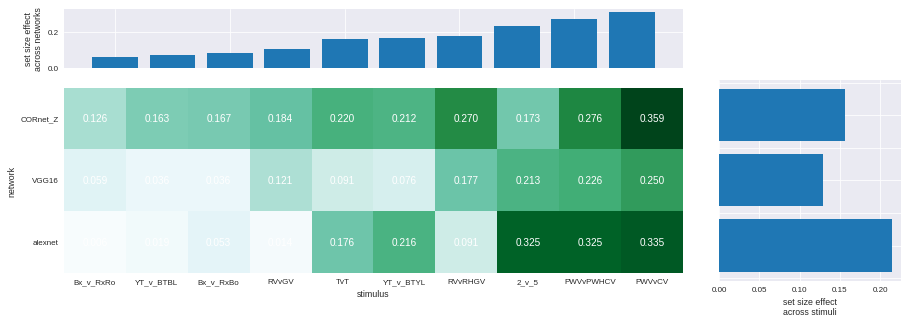

In [23]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(15, 5))

gs = GridSpec(4,4)

ax_joint = fig.add_subplot(gs[1:4,0:3])
ax_marg_x = fig.add_subplot(gs[0,0:3])
ax_marg_y = fig.add_subplot(gs[1:4,3])


ax_joint.imshow(acc_diff_mat, cmap=plt.get_cmap('BuGn'))
ax_joint.grid(False)
ax_joint.set_xticks(np.arange(acc_diff_mat.shape[1]))
ax_joint.set_yticks(np.arange(acc_diff_mat.shape[0]))
ax_joint.set_xticklabels(df_acc_diff_stim_cols.columns)
ax_joint.set_yticklabels(df_acc_diff_stim_cols.index.values)
for i in range(acc_diff_mat.shape[0]):
    for j in range(acc_diff_mat.shape[1]):
        text = ax_joint.text(j, i, f'{acc_diff_mat[i, j]:0.3f}', 
                             ha="center", va="center", color="w")

ax_marg_x.bar(np.arange(len(acc_diff_stim_mean)), acc_diff_stim_mean)
ax_marg_y.barh(np.arange(len(acc_diff_net_mean)), acc_diff_net_mean)

# Turn off tick labels on marginals
plt.setp(ax_marg_x.get_xticklabels(), visible=False)
plt.setp(ax_marg_y.get_yticklabels(), visible=False)

# Set labels on joint
ax_joint.set_xlabel('stimulus')
ax_joint.set_ylabel('network')

# Set labels on marginals
ax_marg_y.set_xlabel('set size effect\nacross stimuli')
ax_marg_x.set_ylabel('set size effect\nacross networks')
plt.show()

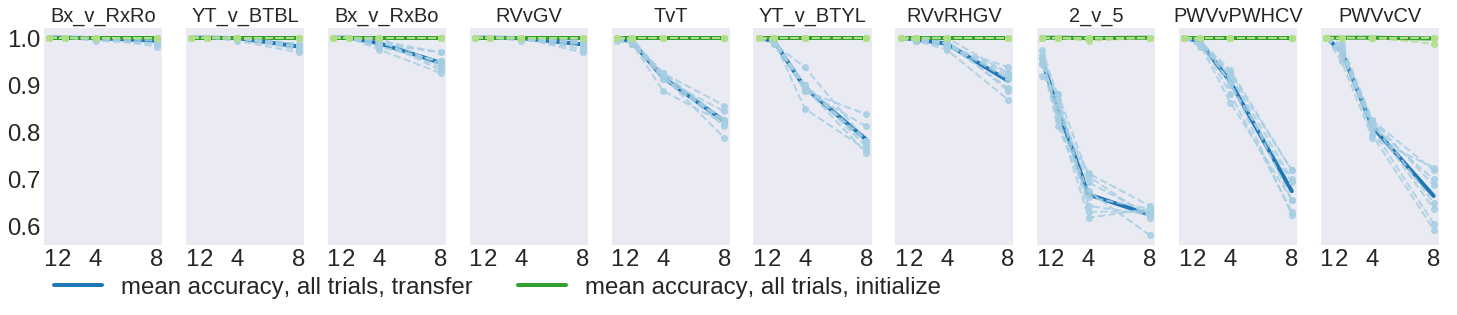

In [51]:
figsize=(25,4)
fig, ax = plt.subplots(1, 10, sharex=True, sharey=True, figsize=figsize)

FONTSIZE = 24
for axis in ax:
    for item in ([axis.title, axis.xaxis.label, axis.yaxis.label] +
                 axis.get_xticklabels() + axis.get_yticklabels()):
        item.set_fontsize(FONTSIZE)

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

add_legend = False

net_name = 'alexnet'
df_alexnet = df_all[df_all['net_name'] == net_name]
for method in ['transfer', 'initialize']:
    for col, stim_name in enumerate(FIG_COLUMNS):
            unit_colors = {'both': cmaps[net_name][method]['unit_both']}
            mn_colors = {'both': cmaps[net_name][method]['mn_both']}

            searchnets.plot.metric_v_set_size_df(df=df_alexnet, 
                                                 net_name=net_name,
                                                 method=method, 
                                                 stimulus=stim_name,
                                                 metric='accuracy', 
                                                 conditions=['both'],
                                                 unit_colors=unit_colors,
                                                 mn_colors=mn_colors,
                                                 set_ylim=False,
                                                 ax=ax[col],
                                                 ylim=(0.5, 1.05),
                                                 add_legend=add_legend)
            ax[col].set_title(stim_name)

handles, labels = ax[0].get_legend_handles_labels()
plt.legend(handles, labels, bbox_to_anchor=(0., -0.2, 0.65, .102), loc='upper left',
           ncol=2, mode="expand", borderaxespad=0., fontsize=FONTSIZE);

# savepath = ROOT.joinpath('docs/static/fig2/searchstims_alexnet_transfer_initialize_128000samples_balanced.png')            
# plt.savefig(savepath, bbox_inches="tight")

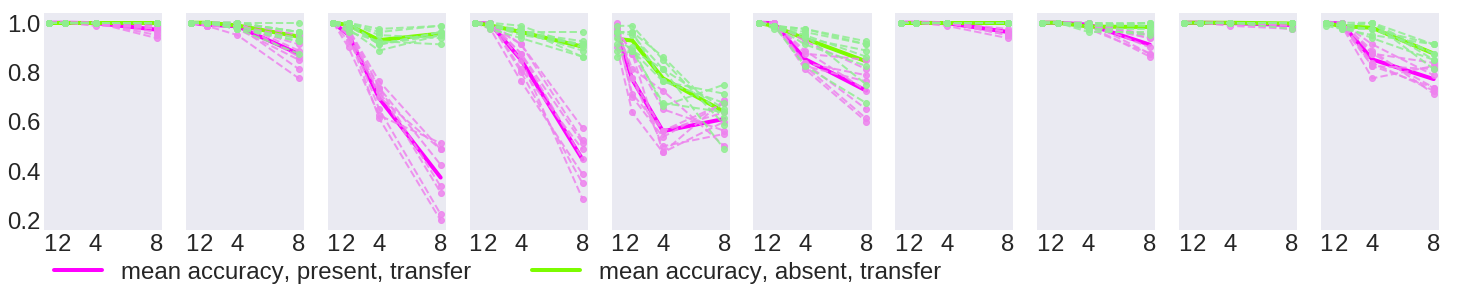

In [11]:
figsize=(25,4)
fig, ax = plt.subplots(1, 10, sharex=True, sharey=True, figsize=figsize)

FONTSIZE = 24
for axis in ax:
    for item in ([axis.title, axis.xaxis.label, axis.yaxis.label] +
                 axis.get_xticklabels() + axis.get_yticklabels()):
        item.set_fontsize(FONTSIZE)

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

add_legend = False
method = 'transfer'

for col, (stim_name, stim_abbrev) in enumerate(zip(
        ['RVvGV', 'RVvRHGV', 'PWVvCV', 'PWVvPWHCV', '2_v_5', 'YT_v_BTYL', 'YT_v_BTBL', 'Bx_v_RxBo', 'Bx_v_RxRo', 'TvT'],
        ['RVvGV', 'RVvRHGV', 'PWVvCV', 'PWVvPWHCV', '2_v_5', 'YT_v_BTYL', 'YT_v_BTBL', 'Bx_v_RxBo', 'Bx_v_RxRo', 'TvT'])):
        unit_colors = {'both': cmaps[net_name][method]['unit_both']}
        mn_colors = {'both': cmaps[net_name][method]['mn_both']}

        searchnets.plot.metric_v_set_size_df(df=df_alexnet, 
                                             net_name='alexnet',
                                             method=method, 
                                             stimulus=stim_abbrev,
                                             metric='accuracy', 
                                             conditions=['present', 'absent'],
                                             set_ylim=False,
                                             ax=ax[col],
                                             ylim=(0.5, 1.05),
                                             add_legend=add_legend)

handles, labels = ax[0].get_legend_handles_labels()
plt.legend(handles, labels, bbox_to_anchor=(0., -0.2, 0.65, .102), loc='upper left',
           ncol=2, mode="expand", borderaxespad=0., fontsize=FONTSIZE);

savepath = ROOT.joinpath('docs/static/fig2/searchstims_alexnet_transfer_initialize_128000samples_balanced_mean_acc_present_absent.png')            
plt.savefig(savepath, bbox_inches="tight")

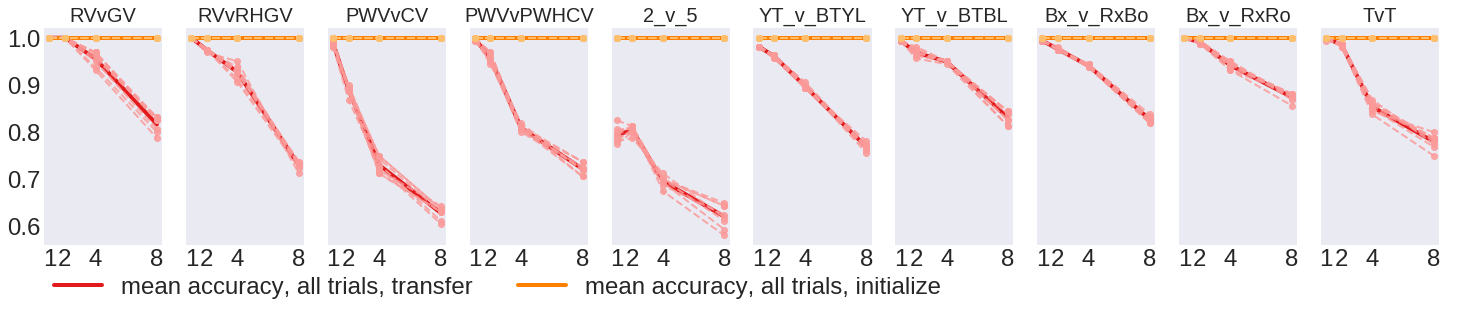

In [13]:
figsize=(25,4)
fig, ax = plt.subplots(1, 10, sharex=True, sharey=True, figsize=figsize)

FONTSIZE = 24
for axis in ax:
    for item in ([axis.title, axis.xaxis.label, axis.yaxis.label] +
                 axis.get_xticklabels() + axis.get_yticklabels()):
        item.set_fontsize(FONTSIZE)

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

add_legend = False

net_name = 'CORnet_Z'
for method in ['transfer', 'initialize']:
    for col, (stim_name, stim_abbrev) in enumerate(zip(
        ['RVvGV', 'RVvRHGV', 'PWVvCV', 'PWVvPWHCV', '2_v_5', 'YT_v_BTYL', 'YT_v_BTBL', 'Bx_v_RxBo', 'Bx_v_RxRo', 'TvT'],
        ['RVvGV', 'RVvRHGV', 'PWVvCV', 'PWVvPWHCV', '2_v_5', 'YT_v_BTYL', 'YT_v_BTBL', 'Bx_v_RxBo', 'Bx_v_RxRo', 'TvT'])):
            unit_colors = {'both': cmaps[net_name][method]['unit_both']}
            mn_colors = {'both': cmaps[net_name][method]['mn_both']}

            searchnets.plot.metric_v_set_size_df(df=df_CORnet_Z, 
                                                 net_name=net_name,
                                                 method=method, 
                                                 stimulus=stim_abbrev,
                                                 metric='accuracy', 
                                                 conditions=['both'],
                                                 unit_colors=unit_colors,
                                                 mn_colors=mn_colors,
                                                 set_ylim=False,
                                                 ax=ax[col],
                                                 ylim=(0.5, 1.05),
                                                 add_legend=add_legend)
            ax[col].set_title(stim_abbrev)

handles, labels = ax[0].get_legend_handles_labels()
plt.legend(handles, labels, bbox_to_anchor=(0., -0.2, 0.65, .102), loc='upper left',
           ncol=2, mode="expand", borderaxespad=0., fontsize=FONTSIZE);

savepath = ROOT.joinpath('docs/static/fig2/searchstims_CORnet_Z_transfer_initialize_128000samples_balanced.png')            
plt.savefig(savepath, bbox_inches="tight")

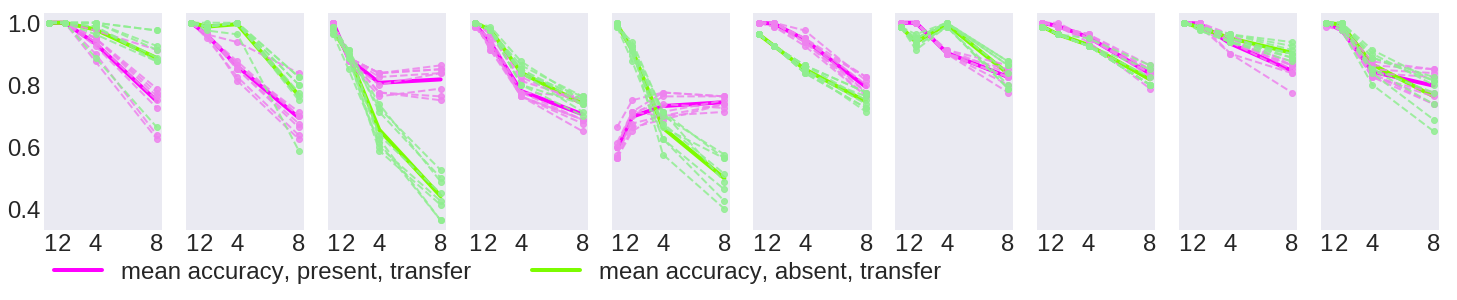

In [14]:
figsize=(25,4)
fig, ax = plt.subplots(1, 10, sharex=True, sharey=True, figsize=figsize)

FONTSIZE = 24
for axis in ax:
    for item in ([axis.title, axis.xaxis.label, axis.yaxis.label] +
                 axis.get_xticklabels() + axis.get_yticklabels()):
        item.set_fontsize(FONTSIZE)

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

add_legend = False
method = 'transfer'

for col, (stim_name, stim_abbrev) in enumerate(zip(
        ['RVvGV', 'RVvRHGV', 'PWVvCV', 'PWVvPWHCV', '2_v_5', 'YT_v_BTYL', 'YT_v_BTBL', 'Bx_v_RxBo', 'Bx_v_RxRo', 'TvT'],
        ['RVvGV', 'RVvRHGV', 'PWVvCV', 'PWVvPWHCV', '2_v_5', 'YT_v_BTYL', 'YT_v_BTBL', 'Bx_v_RxBo', 'Bx_v_RxRo', 'TvT'])):
        unit_colors = {'both': cmaps[net_name][method]['unit_both']}
        mn_colors = {'both': cmaps[net_name][method]['mn_both']}

        searchnets.plot.metric_v_set_size_df(df=df_CORnet_Z, 
                                             net_name='CORnet_Z',
                                             method=method, 
                                             stimulus=stim_abbrev,
                                             metric='accuracy', 
                                             conditions=['present', 'absent'],
                                             set_ylim=False,
                                             ax=ax[col],
                                             ylim=(0.5, 1.05),
                                             add_legend=add_legend)

handles, labels = ax[0].get_legend_handles_labels()
plt.legend(handles, labels, bbox_to_anchor=(0., -0.2, 0.65, .102), loc='upper left',
           ncol=2, mode="expand", borderaxespad=0., fontsize=FONTSIZE);

savepath = ROOT.joinpath('docs/static/fig2/searchstims_CORnet_Z_transfer_initialize_128000samples_balanced_mean_acc_present_absent.png')            
plt.savefig(savepath, bbox_inches="tight")

In [15]:
df_list = []

net_name = 'VGG16'
for method in ['initialize', 'transfer']:
    if method == 'transfer':
        results_gz_path = DATA_DIR.joinpath('results/VGG16_transfer_lr_1e-03_no_finetune_multiple_stims_128000samples_balanced'
                                            '/searchnets_VGG16_transfer_lr_1e-03_no_finetune_multiple_stims_128000samples_balanced_trained_200_epochs_test_results.gz')
    elif method == 'initialize':
        results_gz_path = DATA_DIR.joinpath('results/VGG16_initialize_lr_1e-03_multiple_stims_128000samples_balanced/'
                                            'searchnets_VGG16_initialize_lr_1e-03_multiple_stims_128000samples_balanced_trained_200_epochs_test_results.gz')
    df_list.append(
        searchnets.utils.general.results_df(alexnet_data_csv_path, results_gz_path, net_name, method, learning_rate)
    )

df_VGG16 = pd.concat(df_list)

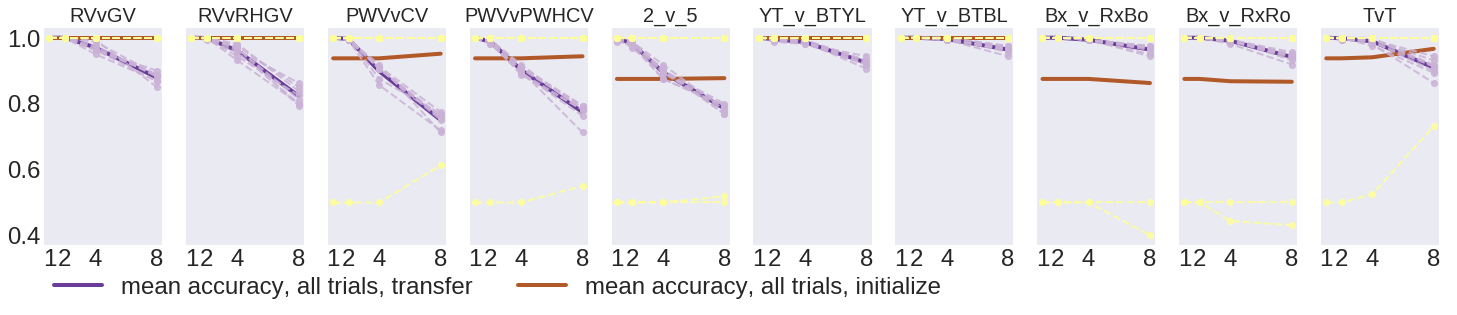

In [16]:
figsize=(25,4)
fig, ax = plt.subplots(1, 10, sharex=True, sharey=True, figsize=figsize)

FONTSIZE = 24
for axis in ax:
    for item in ([axis.title, axis.xaxis.label, axis.yaxis.label] +
                 axis.get_xticklabels() + axis.get_yticklabels()):
        item.set_fontsize(FONTSIZE)

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

add_legend = False

net_name = 'VGG16'
for method in ['transfer', 'initialize']:
    for col, (stim_name, stim_abbrev) in enumerate(zip(
        ['RVvGV', 'RVvRHGV', 'PWVvCV', 'PWVvPWHCV', '2_v_5', 'YT_v_BTYL', 'YT_v_BTBL', 'Bx_v_RxBo', 'Bx_v_RxRo', 'TvT'],
        ['RVvGV', 'RVvRHGV', 'PWVvCV', 'PWVvPWHCV', '2_v_5', 'YT_v_BTYL', 'YT_v_BTBL', 'Bx_v_RxBo', 'Bx_v_RxRo', 'TvT'])):
            unit_colors = {'both': cmaps[net_name][method]['unit_both']}
            mn_colors = {'both': cmaps[net_name][method]['mn_both']}

            searchnets.plot.metric_v_set_size_df(df=df_VGG16, 
                                                 net_name=net_name,
                                                 method=method, 
                                                 stimulus=stim_abbrev,
                                                 metric='accuracy', 
                                                 conditions=['both'],
                                                 unit_colors=unit_colors,
                                                 mn_colors=mn_colors,
                                                 set_ylim=False,
                                                 ax=ax[col],
                                                 ylim=(0.5, 1.05),
                                                 add_legend=add_legend)
            ax[col].set_title(stim_abbrev)

handles, labels = ax[0].get_legend_handles_labels()
plt.legend(handles, labels, bbox_to_anchor=(0., -0.2, 0.65, .102), loc='upper left',
           ncol=2, mode="expand", borderaxespad=0., fontsize=FONTSIZE);

savepath = ROOT.joinpath('docs/static/fig2/searchstims_VGG16_transfer_initialize_128000samples_balanced.png')            
plt.savefig(savepath, bbox_inches="tight")

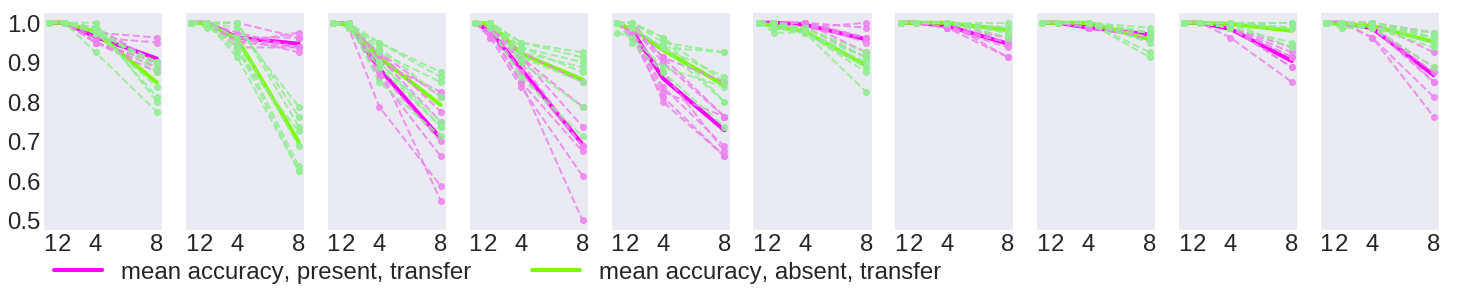

In [18]:
figsize=(25,4)
fig, ax = plt.subplots(1, 10, sharex=True, sharey=True, figsize=figsize)

FONTSIZE = 24
for axis in ax:
    for item in ([axis.title, axis.xaxis.label, axis.yaxis.label] +
                 axis.get_xticklabels() + axis.get_yticklabels()):
        item.set_fontsize(FONTSIZE)

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

add_legend = False
method = 'transfer'

for col, (stim_name, stim_abbrev) in enumerate(zip(
        ['RVvGV', 'RVvRHGV', 'PWVvCV', 'PWVvPWHCV', '2_v_5', 'YT_v_BTYL', 'YT_v_BTBL', 'Bx_v_RxBo', 'Bx_v_RxRo', 'TvT'],
        ['RVvGV', 'RVvRHGV', 'PWVvCV', 'PWVvPWHCV', '2_v_5', 'YT_v_BTYL', 'YT_v_BTBL', 'Bx_v_RxBo', 'Bx_v_RxRo', 'TvT'])):
        unit_colors = {'both': cmaps[net_name][method]['unit_both']}
        mn_colors = {'both': cmaps[net_name][method]['mn_both']}

        searchnets.plot.metric_v_set_size_df(df=df_VGG16, 
                                             net_name='VGG16',
                                             method=method, 
                                             stimulus=stim_abbrev,
                                             metric='accuracy', 
                                             conditions=['present', 'absent'],
                                             set_ylim=False,
                                             ax=ax[col],
                                             ylim=(0.5, 1.05),
                                             add_legend=add_legend)

handles, labels = ax[0].get_legend_handles_labels()
plt.legend(handles, labels, bbox_to_anchor=(0., -0.2, 0.65, .102), loc='upper left',
           ncol=2, mode="expand", borderaxespad=0., fontsize=FONTSIZE);

savepath = ROOT.joinpath('docs/static/fig2/searchstims_VGG16_transfer_initialize_128000samples_balanced_mean_acc_present_absent.png')            
plt.savefig(savepath, bbox_inches="tight")